In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [4]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import norm
import datetime
import yfinance as yf

In [8]:
end = datetime.datetime(2023, 1, 15)
start = end - datetime.timedelta(days = 7*365)


# gets the closing price fo Amazon for the past 5 years
my_stock = yf.Ticker('AMZN')
my_stock = pd.DataFrame(my_stock.history(start = start, end = end)['Close'])
my_stock = my_stock.rename(str.lower, axis = 'columns')

In [9]:
# grabs the last 500 observations, which will be reduced to 250 for the purpose of fitting a
# distribution for Monte Carlo simulation
my_stock_resid_distr_fitting = my_stock[-500:]
# creates a training subset missing the final 500 observations, which are being withheld
my_stock_train = my_stock[~my_stock.isin(my_stock_resid_distr_fitting).all(1)]
# grabs the final 250 observations for a test set
my_stock_test = my_stock_resid_distr_fitting[-250:]
# reduces the distribution fitting dataset to 250 observations (select other than test data from last 500)
my_stock_resid_distr_fitting = my_stock_resid_distr_fitting[~my_stock_resid_distr_fitting.isin(my_stock_test).all(1)]

# plots the my_stock weekly closing price over the past 5 years
px.line(my_stock,x=my_stock.index, y=my_stock.close)

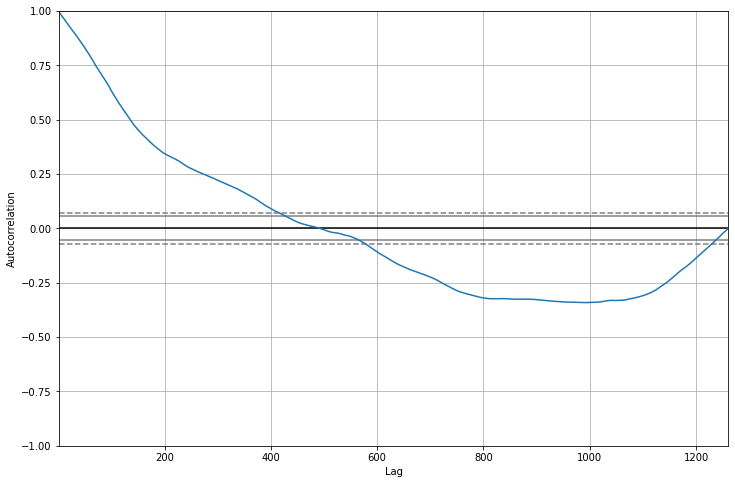

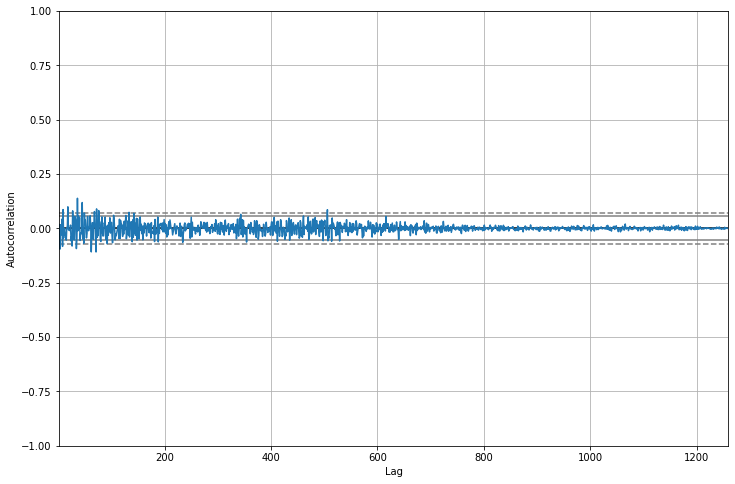

In [10]:
plt.rcParams['figure.figsize'] = (12,8)
pd.plotting.autocorrelation_plot(my_stock_train.close)
plt.show()

#plotting an autocorrelation plot for the difference of the 'close'
#column of the DataFrame my_stock_train after dropping missing values.
pd.plotting.autocorrelation_plot(my_stock_train.close.diff().dropna())
plt.show()

Autocorrelation plot shows 1 for lag(1) else it is okay not much, for lag around 450 acf is 0. If seasonality would be there then we can remove it by lag differencing or other methods

The ADF tests confirm that the stock price is not stationary, but its first difference is. This means the stock price is integrated to the order 1 and will need to be differenced one time for modeling.

In [11]:
from statsmodels.tsa.stattools import adfuller

# performs ADF tests with no constant, a constant, and a constant plus linear trend on
# Amazon closing share prices
for i in ['nc', 'c', 'ct']:
    result = adfuller(my_stock_train.close, regression = i)
    print('ADF Statistic with %s for Closing my_stock price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

# performs ADF tests with no constant, a constant, and a constant plus linear trend on
# differenced Amazon closing share prices
for i in ['nc', 'c', 'ct']:
    result = adfuller(my_stock_train.close.diff().dropna(), regression = i)
    print('ADF Statistic with %s for Differenced Closing my_stock price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc for Closing my_stock price: 2.492982
p-value: 0.998070

ADF Statistic with c for Closing my_stock price: 0.390063
p-value: 0.981119

ADF Statistic with ct for Closing my_stock price: -1.564731
p-value: 0.805939

ADF Statistic with nc for Differenced Closing my_stock price: -8.284509
p-value: 0.000000

ADF Statistic with c for Differenced Closing my_stock price: -8.697486
p-value: 0.000000

ADF Statistic with ct for Differenced Closing my_stock price: -8.754867
p-value: 0.000000



Here I estimated a simple ARIMA model of order (1, 1, 1) on the natural logarithm of the differenced stock prices to control for heteroskedasticity. The residuals on the training data set appear stationary, but somewhere there are some big spikes giving a long tails to the distribution of residuals. As just mentioned, the distribution of residuals have long tails, and the center of the distribution is a sharp peak around zero. Because the mean of the distributions is roughly zero, it seems reasonable to proceed with this simple model. We just need to keep in mind the residuals may be differently distributed than a normal distribution because of the long tails and sharp peak.



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1260
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3211.994
Method:                       css-mle   S.D. of innovations              0.019
Date:                Tue, 17 Jan 2023   AIC                          -6415.989
Time:                        17:30:23   BIC                          -6395.433
Sample:                             1   HQIC                         -6408.264
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.688      0.007       0.000       0.002
ar.L1.D.y     -0.4252      0.262     -1.624      0.104      -0.938       0.088
ma.L1.D.y      0.3708      0.268      1.384      0.1

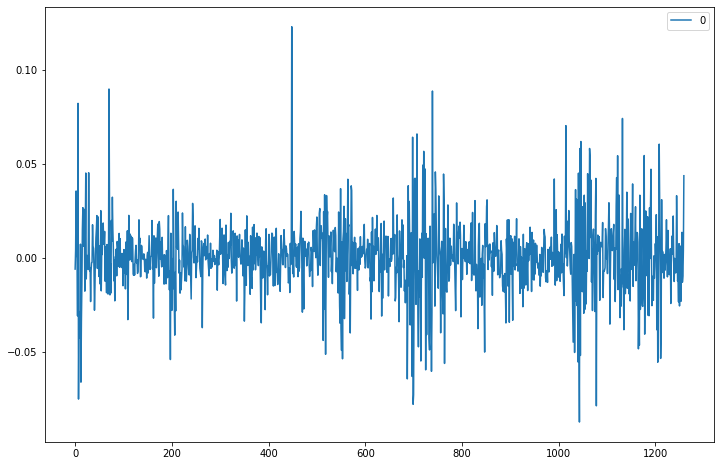

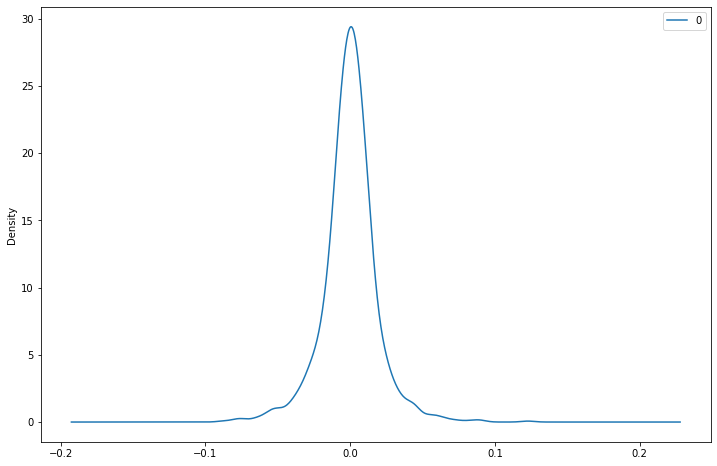

                  0
count  1.260000e+03
mean  -6.952343e-08
std    1.891604e-02
min   -8.745792e-02
25%   -8.450080e-03
50%    3.284593e-04
75%    8.712905e-03
max    1.228531e-01


In [12]:
# imports the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

# fits the ARIMA model
my_stock_arima = ARIMA(np.log(my_stock_train.astype(float).values.reshape(-1).tolist()), order = (1, 1, 1))
my_stock_arima_fit = my_stock_arima.fit(disp = 0)
print(my_stock_arima_fit.summary())

# sets the plot size to 12x8
plt.rcParams['figure.figsize'] = (12,8)

# plot residual errors of the training data
residuals = pd.DataFrame(my_stock_arima_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

After choosing a simple ARIMA model, I performed a rolling forecast on one of the withheld data sets and examined the residuals. It's roughly bell-shaped and appears to be centered at 0. The fitting function indicates the Laplacian distribution is a reasonable distribution to use for our Monte Carlo simulations. Here is an example of automatically assuming a normal distribution getting you into trouble. Often times a different distribution is a better fit, empirically or theoretically (based on existence of bounds, etc). The Laplacian distribution is often a good fit for stock returns because of its fat tails, but again, always check first.

Test MSE: 6.485


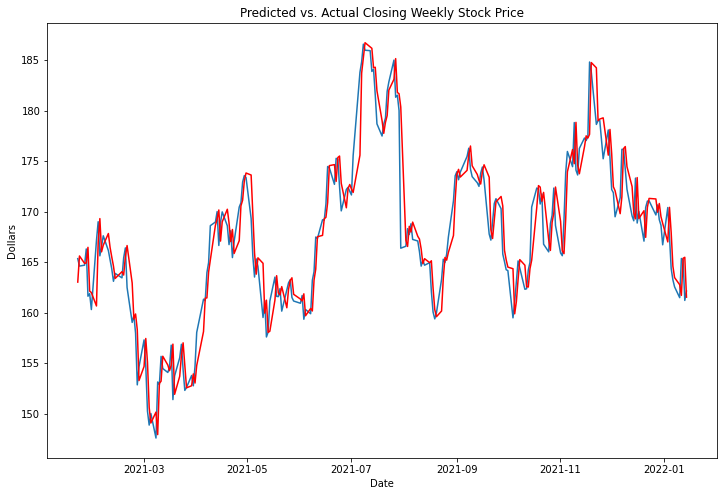

In [14]:
import warnings
warnings.filterwarnings('ignore')

# imports the mean squared error function
from sklearn.metrics import mean_squared_error

# creates a new dataframe that will be added to as the forecast rolls 
history = np.log(my_stock_train.astype(float))
# creates an empty list that will hold predictions
predictions = []
# loops through the indexes of the set being forecased
for i in range(len(my_stock_resid_distr_fitting)):
    # estimates an ARIMA model of order (1,1,1)
    model = ARIMA(history, order = (1,1,1))
    # fits the model
    model_fit = model.fit(disp = 0)
    # forecasts the next period
    output = model_fit.forecast()
    # takes the predicted value and saves it in yhat
    yhat = np.e ** output[0]
    # appends yhat to the list of predictions
    predictions.append(yhat)
    # grabs the observation at the ith index
    obs = my_stock_resid_distr_fitting[i : i + 1]
    # appends the observation to the estimation data set
    history = history.append(np.log(obs.astype(float)))

# prints the MSE of the model for the rolling forecast period
error = mean_squared_error(my_stock_resid_distr_fitting, predictions)
print('Test MSE: %.3f' % error)

# converts the predictions list to a pandas dataframe with the same index as the actual values
# for plotting purposes
predictions = pd.DataFrame(predictions)
predictions.index = my_stock_resid_distr_fitting.index

# sets the plot size to 12x8
plt.rcParams['figure.figsize'] = (12,8)

# plots the predicted and actual stock prices 
plt.plot(my_stock_resid_distr_fitting)
plt.plot(predictions, color = 'red')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.title('Predicted vs. Actual Closing Weekly Stock Price')
plt.show()

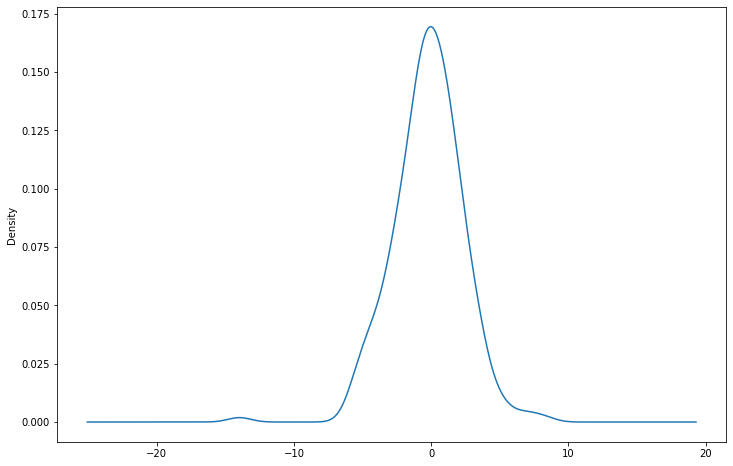

In [15]:
# plots the residuals
tune_residuals = my_stock_resid_distr_fitting.close - predictions[0]
tune_residuals.plot(kind = 'kde')

In [16]:
!pip install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fitter: filename=fitter-1.5.2-py3-none-any.whl size=25609 sha256=acfc8f63fff4294ce1b45854a226c59a6eb3a5f31c6398ad6f4759bd689d3ce3
  Stored in directory: /root/.cache/pip/wheels/8e/6b/cb/628035771acab95dc84f200590b4838c7c3095a70ede67a25a
Successfully built fitter


In [17]:
# produces a summary of the residuals
tune_residuals.astype(float).describe()

# imports the fitter function and produces estimated fits for our residuals
from fitter import Fitter

f = Fitter(tune_residuals)
f.fit()
#f.summary

Fitting 106 distributions: 100%|██████████| 106/106 [01:40<00:00,  1.06it/s]


<bound method Fitter.summary of <fitter.fitter.Fitter object at 0x7fadd0caa0d0>>

              sumsquare_error         aic          bic  kl_div  ks_statistic  \
genlogistic          0.066510  934.105251 -2041.399965     inf      0.021148   
norminvgauss         0.066545  931.482042 -2035.749464     inf      0.021244   
johnsonsu            0.066690  931.207752 -2035.206291     inf      0.021275   
burr12               0.066804  949.024484 -2034.776507     inf      0.023482   
nct                  0.066876  931.539769 -2034.506866     inf      0.021730   

              ks_pvalue  
genlogistic    0.999782  
norminvgauss   0.999762  
johnsonsu      0.999755  
burr12         0.998653  
nct            0.999637  


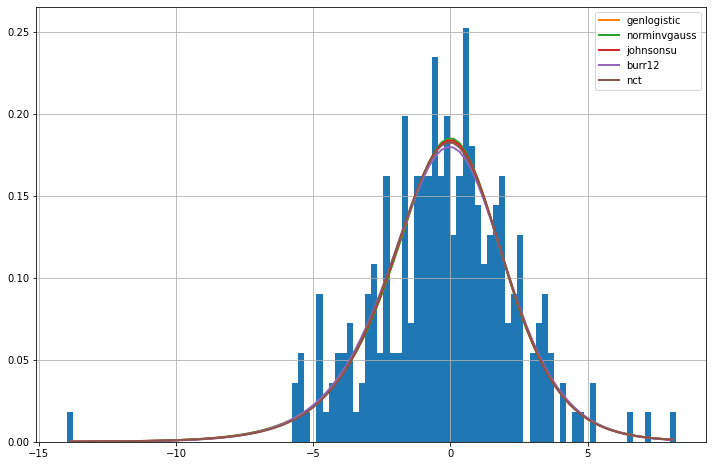

In [18]:
print(f.summary())

In [19]:
# creates a function to do MC simulation with a Laplacian distribution
def laplace_monte_carlo(mean, residuals, n_sims):
    # gets the estimated beta or mean absolute distance from the mean
    beta = (sum(abs(residuals - np.mean(residuals))) 
                           / len(residuals))
    # uses the numpy function to generate an array of simulated values
    est_range = np.random.laplace(mean, beta, n_sims)
    # converts the array to a list
    est_range = list(est_range)
    # returns the simulated values
    return(est_range)

def roll_forecast_nmc(train, test, std_dev, n_sims):
    # creates a new dataframe that will be added to as the forecast rolls 
    history = np.log(train.astype(float))
    # creates an empty list that will hold predictions
    predictions = []
    # loops through the indexes of the set being forecased
    for i in range(len(test)):
        # estimates an ARIMA model of order (1,1,0)
        model = ARIMA(history, order = (1,1,1))
        # fits the model
        model_fit = model.fit(disp = 0)
        # forecasts the next period
        output = model_fit.forecast()
        # takes the predicted value and saves it in yhat
        yhat = np.e ** output[0]
        # performs monte carlo simulation using the predicted price as the mean, user-specified
        # standard deviation, and number of simulations
        yhat_range = laplace_monte_carlo(yhat, std_dev, n_sims)
        # appends yhat_range to the list of predictions
        predictions.append([float(i) for i in yhat_range])
        # grabs the observation at the ith index
        obs = test[i : i + 1]
        # appends the observation to the estimation data set
        history = history.append(np.log(obs.astype(float)))

    # converts the predictions list to a pandas dataframe with the same index as the actual 
    # values for plotting purposes
    predictions = pd.DataFrame(predictions)
    predictions.index = my_stock_resid_distr_fitting.index
    # converts all the estimated yhats in each column to one list per row
    predictions['predicted_range'] = predictions.values.tolist()
    # grabs only the column with all values in a list
    predictions = pd.DataFrame(predictions['predicted_range'])
    return predictions

In [20]:
# attaches the data withheld for investigating the forecast residuals back to the training
# data set to avoid a large error on the first forecast
my_stock_train = my_stock_train.append(my_stock_resid_distr_fitting)


# produces a rolling forecast with prediction intervals using 1000 MC sims
test_preds = roll_forecast_nmc(my_stock_train, 
                               my_stock_test, 
                               tune_residuals,
                              1000)
# creates an empty list
in_prediction_interval = []
# loops through the rows in the testing data set
for i in range(len(my_stock_test)):
    # appends true if the actual price is in the interval of predicted prices and false
    # otherwise
    in_prediction_interval.append(np.where(min(test_preds.predicted_range[i]) <= 
                                           my_stock_test.close[i]
                                          <= max(test_preds.predicted_range[i]), 
                                           True, False))
# prints the percentage of actual prices in the prediction intervals    
print('Percentage of Actual Stock Prices in Predicted Stock Price Range: %f' % 
      (100 * sum(in_prediction_interval) / len(in_prediction_interval)))

Percentage of Actual Stock Prices in Predicted Stock Price Range: 98.800000


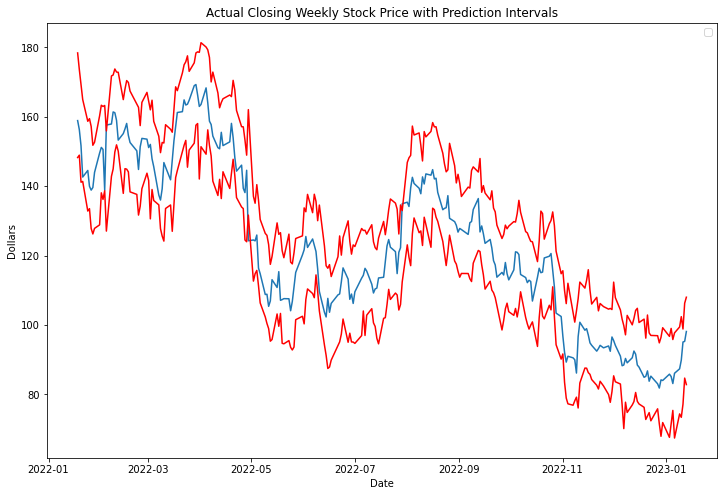

In [32]:
# creates empty lists to append to with minimum and maximum values for each weeks prediction
min_range = []
max_range = []

# loops through the rows in test_preds
for i in range(len(test_preds)):
    # appends to the list the min or max value as appropriate
    min_range.append(min(test_preds.predicted_range[i]))
    max_range.append(max(test_preds.predicted_range[i]))

# converts the lists to data frames and makes their indexes match up with the dates they're
# predicting
min_range = pd.DataFrame(min_range)
min_range.index = my_stock_test.index
max_range = pd.DataFrame(max_range)
max_range.index = my_stock_test.index

# plots the actual stock price with prediction intervals
plt.plot(my_stock_test)
plt.plot(min_range, color = 'red')
plt.plot(max_range, color = 'red')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.title('Actual Closing Weekly Stock Price with Prediction Intervals')
plt.legend()
plt.show()

Red color shows minimum and maximum range of fluctuation

In [37]:
# sets a target price to see the probability that the actual stock price is greater than or 
# equal to this target
target_price = 90
# creates a list of True values where the simulated price is above or equal to the target price
# and False where it is below
above_target = [i >= target_price for i in test_preds.predicted_range[len(test_preds) - 1]]
# prints the probability
print('Probability Actual Stock Price is above Strike Price: %f' % 
      (sum(above_target) / len(above_target)))

Probability Actual Stock Price is above Strike Price: 0.967000
